In [22]:
#Import the required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from fbprophet import Prophet
import pandas
import math

In [23]:
def round_down(n, decimals=0):
    multiplier = 1 ** decimals
    return math.floor(n * multiplier) / multiplier

In [24]:
#Import the train dataset
train_data = pd.read_csv('dataset/dataset.csv', sep=';')
train_data.head()

,DateTime,Occupants
0,2019-03-10 18:00,35
1,2019-03-10 19:00,36
2,2019-03-10 20:00,38
3,2019-03-10 21:00,38
4,2019-03-10 22:00,35


In [25]:
#Import the test dataset
test_data = pd.read_csv('dataset/prediction_set.csv', sep=';')
test_data.head()

,DateTime,Occupants
0,2020-04-05 08:00:00,16
1,2020-04-05 09:00:00,16
2,2020-04-05 10:00:00,17
3,2020-04-05 11:00:00,19
4,2020-04-05 12:00:00,23


In [26]:
train_data.shape

(9390, 2)

In [27]:
test_data.shape

(16, 2)

In [28]:
#Data Pre-processing

# Convert to datetime format
train_data['DateTime'] = pd.to_datetime(train_data['DateTime']) 
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])
train_data['hour'] = train_data.DateTime.dt.hour

# Calculate average hourly fraction
hourly_frac = train_data.groupby(['hour']).mean()/np.sum(train_data.groupby(['hour']).mean())
hourly_frac.columns = ['fraction']

# Convert dataframe to time series 
train_data.index = train_data.DateTime
train_data.drop(['hour','DateTime'], axis = 1, inplace = True)

# Resampling to reduce noise
train_data = train_data.resample('D').sum()

# Assign prophet variable names
train_data['ds'] = train_data.index
train_data['y'] = train_data.Occupants
train_data.drop(['Occupants'],axis = 1, inplace = True)

In [29]:
# Model

model = Prophet(daily_seasonality = True, weekly_seasonality = True, yearly_seasonality = True, seasonality_prior_scale=0.1)
model.fit(train_data)

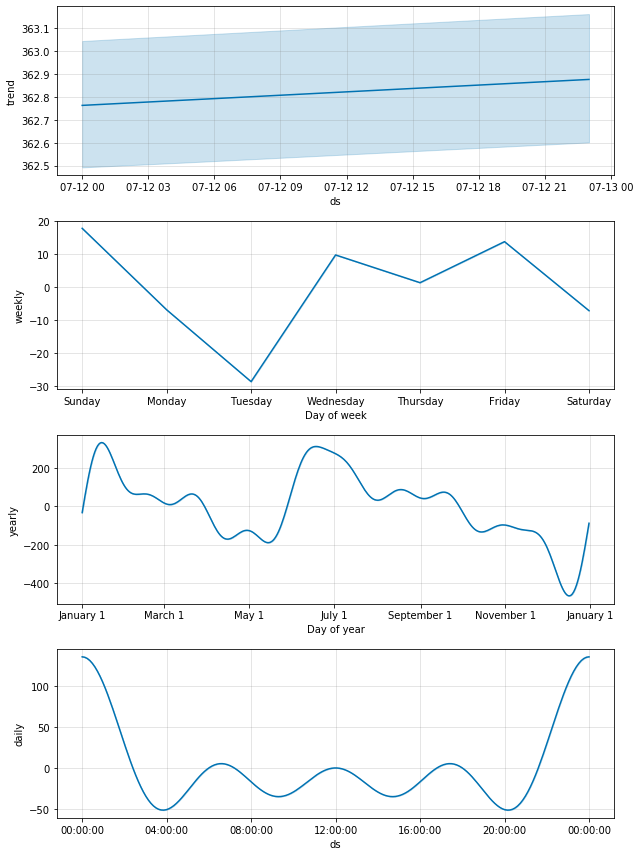

In [30]:
# Forecast for the current day

current_datetime = pandas.datetime.today().strftime("%Y-%m-%d")
future_dataframe = pandas.date_range(current_datetime, periods=24, freq='H')
future_dataset = pandas.DataFrame({ 'ds': future_dataframe }) 
forecast = model.predict(future_dataset)
figure = model.plot_components(forecast)

In [31]:
# Obtain hourly prediction values and copy to a csv file

# Extract hour, day, month and year from the forecast
for df in [forecast]:
    forecast['hour'] = forecast.ds.dt.hour
    forecast['day'] = forecast.ds.dt.day
    forecast['month'] = forecast.ds.dt.month
    forecast['year'] = forecast.ds.dt.year

cols = ['hour','yhat']
forecast = forecast[cols]

# Merging hourly average fraction to the forecast data
forecast_new = pd.merge(forecast, hourly_frac, left_on = ['hour'], right_index=True, how = 'left')

# Convert daily aggregate to hourly traffic
forecast_new['Occupants'] = forecast_new['yhat'] * forecast_new['fraction']

for i in range(len(forecast_new)):
    forecast_new.loc[i, 'Occupants'] = round_down(forecast_new.loc[i, 'Occupants'])

forecast_new.drop(['yhat','fraction', 'hour'],axis = 1, inplace = True)
forecast_new.to_csv('prophet_prediction.csv',index = False)